Units used: GeV for masses, s for time, cm for distances

In [53]:
import os
import glob
import importlib

import matplotlib as mlib
import matplotlib.pyplot as plt

# plt.rcParams["text.usetex"] = True
# plt.rcParams["text.latex.preamble"] = r"\usepackage{slashed}"

import numpy as np
from numpy import genfromtxt
from numpy import loadtxt
import re
import csv
import matplotlib.colors as mcolors
import matplotlib.cm as cm
import matplotlib.patches as mpatches
import matplotlib.lines as mlines


import sys
sys.path.insert(1, '/home/stasya/prj/alps-running/TdAlps-Internal/')
import TdAlps
from collections import OrderedDict

import scipy
import scipy.integrate as integrate
import scipy.optimize as optimize

import csv

In [54]:
#Plotting settings

font = {
        'weight' : 'normal',
        'size'   : 16}

mlib.rc('font', **font)

In [55]:
def importNotebook(name):
    
    currentDir=os.getcwd()
    notebookDir=os.path.dirname(name)
    os.chdir(notebookDir)
    notebookName=os.path.basename(name).split('.')[0]
    module = importlib.import_module(f"ipynb.fs.full.{notebookName}")
    
    os.chdir(currentDir)
    
    globals().update(vars(module))

In [56]:
importNotebook("/home/stasya/prj/alps/Python/ALPs_base.ipynb")

In [57]:
importNotebook("/home/stasya/prj/alps/Python/ALPs_BRs.ipynb")

### mass-coupling grid

In [58]:
#masslist= [0.05, 0.05, 0.1, 0.2, 0.3, 0.5, 1., 2., 4.]
masslist=np.sort(np.append(np.logspace(-2, 0, 25),[0.09, 0.101, 0.43, 0.47,0.55,\
                                                   0.95, 1, 1.5, 2, 2.5, 3, 3.2, 3.5, 4,\
                                                   0.0935, 0.095, 0.63, 0.65]))
masslistShort=np.logspace(-2,np.log(2.1), 40)
particleCodes=[*range(0,7,1)]

In [59]:
masslistShort

array([0.01      , 0.01175726, 0.01382331, 0.01625243, 0.0191084 ,
       0.02246624, 0.02641414, 0.03105579, 0.0365131 , 0.0429294 ,
       0.0504732 , 0.05934265, 0.06977069, 0.08203121, 0.09644622,
       0.11339432, 0.13332063, 0.15674852, 0.1842933 , 0.2166784 ,
       0.25475441, 0.29952136, 0.35215502, 0.41403778, 0.48679494,
       0.57233742, 0.67291193, 0.79115999, 0.93018729, 1.09364529,
       1.28582709, 1.51178022, 1.77743916, 2.08978126, 2.45700995,
       2.88877024, 3.396402  , 3.9932378 , 4.69495311, 5.51997797])

In [60]:
couplingList=np.sort(np.append(np.logspace(-6, 4, 20),np.logspace(-1, 2, 20)))
couplingListShort=np.logspace(np.log(8*10**-4), np.log(1.7), 25)
couplingListExtended=np.sort(np.append(np.logspace(-6, 7, 40),np.logspace(-1, 2, 20)))

In [61]:
couplingListShort

array([7.39777588e-08, 1.54287757e-07, 3.21782010e-07, 6.71107442e-07,
       1.39965935e-06, 2.91912468e-06, 6.08811630e-06, 1.26973542e-05,
       2.64815579e-05, 5.52298451e-05, 1.15187173e-04, 2.40233968e-04,
       5.01031130e-04, 1.04494879e-03, 2.17934156e-03, 4.54522719e-03,
       9.47951003e-03, 1.97704332e-02, 4.12331468e-02, 8.59957079e-02,
       1.79352350e-01, 3.74056638e-01, 7.80131225e-01, 1.62703897e+00,
       3.39334683e+00])

In [62]:
BelleIIparams={
    'gammaBoostB': 1.03029,
    'RCDC': 60, #cm
    'thetaCDCMin': np.deg2rad(17),
    'thetaCDCMax': np.deg2rad(150),
    'dres': 0.9,
    'NBBelleII': 5*10**10
}

In [63]:
def f(Lambda):
    return Lambda/(4 * np.pi)

In [64]:
constants={
    'InvGeVtocm': 1/(5.06 * 10**(13))
}

In [65]:
sm['tauB+'] = 1.638*10**(-12)
sm['ctauB+']= 3 * 10**10 * 1.638*10**(-12)

## based on https://github.com/rrschaefer/alps (formulas taken from 2012.12272 and 1708.00443)

### Alps running implemented in https://github.com/TdAlps

### ALP and B-> Ka decay rates

In [66]:
def BrBtoKaplus(ma, cbs, Lambda):
    return (np.pi/4)*abs(cbs)**2/(Lambda**2) * abs(formFactorFzeroBplus(ma))**2 \
            * (sm['mB+']**2-sm['mK+']**2)**2/sm['mB+']**3 * np.sqrt(sm['mB+']**4+sm['mK+']**4+ma**4\
            -2*(sm['mB+']**2 * sm['mK+']**2 + sm['mK+']**2 * ma**2 + ma**2 * sm['mB+']**2))\
            /sm['hbar']*sm['tauB+']

### ALP branching ratios

### decays under consideration encoded as
 - 0: e 
 - 1: mu
 - 2: tau
 - 3: charm
 - 4: bottom
 - 5: photon
 - 6: hadron
 - 7: 3 pions

In [67]:
def brALPtoOneFinalState(ma,finalStateCode,cQ,cu,cd,cL,ce,cGG,cWW,cBB,Lambda,lscsPassed=None):
    with HiddenPrints():
        HC = OrderedDict()
        HC['Q'] = np.array([[cQ,0,0],[0,cQ,0],[0,0,cQ]])
        HC['u'] = -np.array([[cu,0,0],[0,cu,0],[0,0,cu]])
        HC['d'] = -np.array([[cd,0,0],[0,cd,0],[0,0,cd]])
        HC['L'] = np.array([[cL,0,0],[0,cL,0],[0,0,cL]])
        HC['e'] = -np.array([[ce,0,0],[0,ce,0],[0,0,ce]])
        HC['GG'] = cGG
        HC['WW'] = cWW
        HC['BB'] = cBB

        brs = [[],[],[],[],[],[],[],[],[]]
        
        if (lscsPassed is not None):
            lscs=lscsPassed
        else:
            if ma<1:
                mu = 1
            else:
                mu=ma
            lscs = TdAlps.RunRotateMatchRun(HC, Lambda, mu, 3)
        
#         print("mu= ",mu)
#         print("readCee= ",readCee(lscs),", readCmumu= ",readCmumu(lscs))
#         print([ma,readCee(lscs),sm['me'],Lambda])
#         print("Gamma_ll= ",Gammaatoll(ma,readCee(lscs),sm['me'],Lambda))
        
        brs[0].append(Gammaatoll(ma,readCee(lscs),sm['me'],Lambda))
        brs[1].append(Gammaatoll(ma,readCmumu(lscs),sm['mmu'],Lambda))
        try:
            ctautau = readCtautau(lscs)
        except IndexError:
            ctautau = 0
        brs[2].append(Gammaatoll(ma,ctautau,sm['mtau'],Lambda))
        try:
            ccc = readCcc(lscs)
        except IndexError:
            ccc = 0
        brs[3].append(Gammaatoqq(ma,ccc,sm['mc'],Lambda))
        try:
            cbb = readCbb(lscs)
        except IndexError:
            cbb = 0
        brs[4].append(Gammaatoqq(ma,cbb,sm['mb'],Lambda))
        brs[5].append(Gammaatogamgam(ma,lscs,Lambda))
        brs[6].append(Gammaatohad(ma,lscs,Lambda))
        brs[7].append(Gammaato3pi000(ma,lscs,Lambda)+Gammaato3pi0pm(ma,lscs,Lambda))
        brs[8].append(brs[0][-1]+brs[1][-1]+brs[2][-1]+brs[3][-1]+brs[4][-1]+brs[5][-1]\
                      +brs[6][-1]+brs[7][-1])
            

#         print("br[0][-1]= ",brs[0][-1])
        
        ctauAlp=constants['InvGeVtocm']/brs[8][-1]

        return [brs[finalStateCode][-1]/brs[8][-1],ctauAlp]

In [68]:
brALPtoOneFinalState(0.1,5,1,-1,-1,1,-1,0,0,0,4*np.pi*10**3,lscsPassed=None)

[0.8831414309179431, 147387308.30504933]

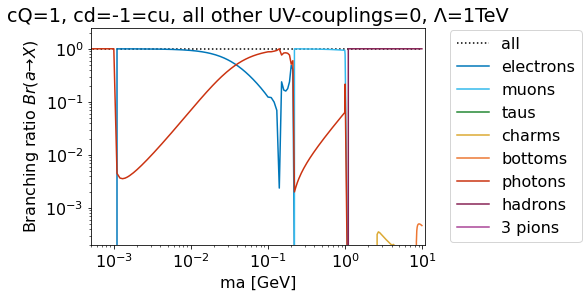

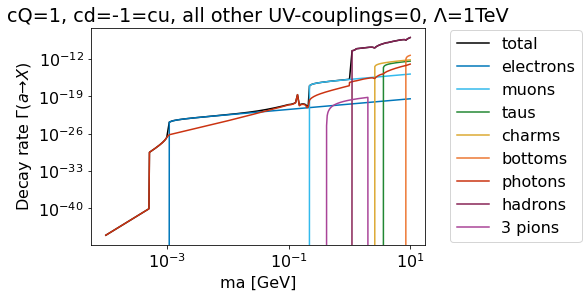

In [69]:
brsALP(1,1,1,0,0,0,0,0,"cQ=1, cd=-1=cu, all other UV-couplings=0, \u039B=1TeV",1000)
brsALP(1,1,1,0,0,0,0,0,"cQ=1, cd=-1=cu, all other UV-couplings=0, \u039B=1TeV",1000,br=False)

## Integral over detector

In [70]:
def gammaBeta(gammaParent,mParent,ma):
    return np.sqrt(gammaParent**2 * (sm['mB+']**2-sm['mK+']**2+ma**2)**2/(4*sm['mB+']**2*ma**2)-1)
    
def gammaBetaAlp(ma):
    return gammaBeta(BelleIIparams['gammaBoostB'],sm['mB+'],ma)

In [71]:
def thetaMinBoost(thetaMin,r,ctau,gammaBeta):
    return np.arctan(r/(r/np.tan(thetaMin) - gammaBeta * ctau))

def thetaMaxBoost(thetaMin,r,ctau,gammaBeta):
    return np.pi+np.arctan(-r/(-r/np.tan(thetaMin) + gammaBeta * ctau))

def geomInt(thetaMin,thetaMax,dmin,dmax,ctau,gammaBeta):
    return 1/(4 * (gammaBeta * ctau)**2) * integrate.quad(lambda theta: (1/np.sin(theta)) \
            * (np.exp(-dmin/(np.sin(theta) * gammaBeta * ctau)) * (dmin**2 + 2 * gammaBeta * ctau * np.sin(theta) \
            * (dmin + gammaBeta * ctau * np.sin(theta)))\
            - np.exp(-dmax/(np.sin(theta) * gammaBeta * ctau)) * (dmax**2 + 2 * gammaBeta * ctau * np.sin(theta) \
            * (dmax + gammaBeta * ctau * np.sin(theta))))\
            , thetaMin, thetaMax)[0]
    
def geomIntBelleIICDC(thetaMin,thetaMax,dmin,dmax,ctau,gammaBeta):
    return np.heaviside(np.real(BelleIIparams['RCDC']/np.tan(thetaMin)-BelleIIparams['gammaBoostB'] * sm['ctauB+']),1)\
            * geomInt(thetaMin,thetaMax,dmin,dmax,ctau,gammaBeta)
                                                

# Number of signal events

In [72]:
BelleIIparams={
    'gammaBoostB': 1.03029,
    'RCDC': 60, #cm
    'thetaCDCMin': np.deg2rad(17),
    'thetaCDCMax': np.deg2rad(150),
    'dres': 0.9,
    'NBBelleII': 5*10**10
}

In [73]:
def nsignalBelleII(ma,finalStateCode,cff,cGG,cWW,cBB,Lambda):
    with HiddenPrints():
#         print(cff)
        cQ = cu = cd = cL = ce = cff

        coefs=getLScoefficients(cff, cWW, cBB, Lambda, ma)
        cbs=getCbs(cff, cWW, cBB, Lambda, sm['mB+'])
#         print("cbs= ",cbs)

        
#     print("BR(B-> K+ a)= ",BrBtoKaplus(ma, cbs, Lambda))    
    
#     #rewrite brALPtoOneFinalState such that last agr can be not a None 
#     print("BR(a->final)= ",brALPtoOneFinalState(ma,finalStateCode,cQ,cu,cd,cL,ce,cGG,cWW,cBB,Lambda,None)[0])
    
#     print([thetaMinBoost(BelleIIparams['thetaCDCMin'],BelleIIparams['RCDC'],sm['ctauB+']\
#     ,gammaBetaAlp(ma)),thetaMaxBoost(BelleIIparams['thetaCDCMax'],BelleIIparams['RCDC'],sm['ctauB+']\
#     ,gammaBetaAlp(ma)),BelleIIparams['dres'],BelleIIparams['RCDC']\
#     ,brALPtoOneFinalState(ma,finalStateCode,cQ,cu,cd,cL,ce,cGG,cWW,cBB,Lambda,None)[1],gammaBetaAlp(ma)])
    
#     print(geomIntBelleIICDC(thetaMinBoost(BelleIIparams['thetaCDCMin'],BelleIIparams['RCDC'],sm['ctauB+']\
#     ,gammaBetaAlp(ma)),thetaMaxBoost(BelleIIparams['thetaCDCMax'],BelleIIparams['RCDC'],sm['ctauB+']\
#     ,gammaBetaAlp(ma)),BelleIIparams['dres'],BelleIIparams['RCDC']\
#     ,brALPtoOneFinalState(ma,finalStateCode,cQ,cu,cd,cL,ce,cGG,cWW,cBB,Lambda,None)[1],gammaBetaAlp(ma)))
    
        return BelleIIparams['NBBelleII'] * BrBtoKaplus(ma, cbs, Lambda) \
        * brALPtoOneFinalState(ma,finalStateCode,cQ,cu,cd,cL,ce,cGG,cWW,cBB,Lambda,None)[0]\
        * geomIntBelleIICDC(thetaMinBoost(BelleIIparams['thetaCDCMin'],BelleIIparams['RCDC'],sm['ctauB+']\
        ,gammaBetaAlp(ma)),thetaMaxBoost(BelleIIparams['thetaCDCMax'],BelleIIparams['RCDC'],sm['ctauB+']\
        ,gammaBetaAlp(ma)),BelleIIparams['dres'],BelleIIparams['RCDC']\
        ,brALPtoOneFinalState(ma,finalStateCode,cQ,cu,cd,cL,ce,cGG,cWW,cBB,Lambda,None)[1],gammaBetaAlp(ma))

In [74]:
nsignalBelleII(0.01,5,10**-6,0,0,0,4*np.pi*10**3)

/tmp/ipykernel_167484/2346480957.py:8: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  return 1/(4 * (gammaBeta * ctau)**2) * integrate.quad(lambda theta: (1/np.sin(theta)) \


2.6721296250648788e-20

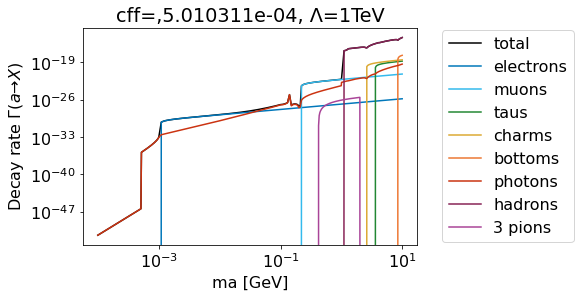

In [22]:
brsALP(5.010311e-04,-5.010311e-04,-5.010311e-04,5.010311e-04,-5.010311e-04,0,0,0,"cff=,5.010311e-04, \u039B=1TeV",1000,br=False,lower=10**-20)

In [80]:

# def nsignalAt95CLBelleIIAllcEqual(cff,ma,finalStateCode,Lambda,nOfEventsAt95CL):
#     cQ=cL=cWW=cBB=cff
#     ce=cd=cu=-cff
#     cGG=0
#     return nsignalBelleII(ma,finalStateCode,cQ,cu,cd,cL,ce,cGG,cWW,cBB,Lambda)-nOfEventsAt95CL

def nsignalAt95CLBelleIIcff(cff,ma,finalStateCode,Lambda,nOfEventsAt95CL):
    cGG=cWW=cBB=0
#     cQ=cL=cff
#     ce=cd=cu=-cff
    return nsignalBelleII(ma,finalStateCode,cff,cGG,cWW,cBB,Lambda)-nOfEventsAt95CL


# def nsignalAt95CLBelleIIcWW(cWW,ma,finalStateCode,Lambda,nOfEventsAt95CL):
#     cQ=cL=cu=cd=ce=cGG=cBB=0
#     res = []
#     for i in np.asarray(cWW):
#         res_i = nsignalBelleII(ma,finalStateCode,cQ,cu,cd,cL,ce,cGG,i,cBB,Lambda)-nOfEventsAt95CL
#         res.append(res_i)
#     return np.array(res)

def nsignalAt95CLBelleIIcWW(cWW,ma,finalStateCode,Lambda,nOfEventsAt95CL):
#     cQ=cL=cu=cd=ce=cGG=cBB=0
    cGG=cBB=0
    cff=0
    return nsignalBelleII(ma,finalStateCode,cff,cGG,cWW,cBB,Lambda)-nOfEventsAt95CL

In [81]:
nsignalAt95CLBelleIIcff(0.0001,0.01,1,4*np.pi*10**3,3)

/tmp/ipykernel_167484/2346480957.py:8: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  return 1/(4 * (gammaBeta * ctau)**2) * integrate.quad(lambda theta: (1/np.sin(theta)) \


-3.0

### decays under consideration encoded as
 - 0: e 
 - 1: mu
 - 2: tau
 - 3: charm
 - 4: bottom
 - 5: photon
 - 6: hadron
 - 7: 3 pions

In [97]:
def visibleBoundBelleIIcffEqcWWEqcBB(ma,finalStateCode,Lambda,nOfEventsAt95CL):
    nsignalAt95CLBelleIIAllcEqualEstimate=np.vstack(([coupling,nsignalAt95CLBelleIIAllcEqual(\
                    coupling,ma,finalStateCode,Lambda,nOfEventsAt95CL)] for coupling in couplingList))
    
#     print([nsignalAt95CLBelleIIAllcEqual(couplingList[0],ma,finalStateCode,Lambda,nOfEventsAt95CL),\
#           nsignalAt95CLBelleIIAllcEqual(nsignalAt95CLBelleIIAllcEqualEstimate[\
#         np.argmax(nsignalAt95CLBelleIIAllcEqualEstimate[:,1]>0),0],ma,finalStateCode,Lambda,nOfEventsAt95CL)])
    
    if (np.argmax(nsignalAt95CLBelleIIAllcEqualEstimate[:,1]>0)==0):
        root1=root2=np.nan
    else:
        root1=optimize.brentq(nsignalAt95CLBelleIIAllcEqual, couplingList[0],\
            nsignalAt95CLBelleIIAllcEqualEstimate[np.argmax(nsignalAt95CLBelleIIAllcEqualEstimate[:,1]>0),0],\
                          args = (ma,finalStateCode,Lambda,nOfEventsAt95CL))

        root2=optimize.brentq(nsignalAt95CLBelleIIAllcEqual,\
            nsignalAt95CLBelleIIAllcEqualEstimate[np.argmax(nsignalAt95CLBelleIIAllcEqualEstimate[:,1]>0),0],\
                              couplingList[-1], args = (ma,finalStateCode,Lambda,nOfEventsAt95CL))
    return [root1,root2]

def visibleBoundBelleIIcff(ma,finalStateCode,Lambda,nOfEventsAt95CL):
    nsignalAt95CLBelleIIcffEstimate=np.vstack(([coupling,nsignalAt95CLBelleIIcff(coupling,ma,finalStateCode,\
                                                Lambda,nOfEventsAt95CL)] for coupling in couplingListExtended))
#     print(nsignalAt95CLBelleIIcffEstimate)
    if (np.argmax(nsignalAt95CLBelleIIcffEstimate[:,1]>0)==0):
        root1=root2=np.nan
    else:
        root1=optimize.brentq(nsignalAt95CLBelleIIcff, couplingListExtended[0],\
            nsignalAt95CLBelleIIcffEstimate[np.argmax(nsignalAt95CLBelleIIcffEstimate[:,1]>0),0],\
                          args = (ma,finalStateCode,Lambda,nOfEventsAt95CL))
#         print("argmax>0= ",nsignalAt95CLBelleIIcffEstimate[np.argmax(nsignalAt95CLBelleIIcffEstimate[:,1]>0),0])
#         print(root1)

        root2=optimize.brentq(nsignalAt95CLBelleIIcff,\
            nsignalAt95CLBelleIIcffEstimate[np.argmax(nsignalAt95CLBelleIIcffEstimate[:,1]>0),0],\
                              couplingListExtended[-1], args = (ma,finalStateCode,Lambda,nOfEventsAt95CL))
#         print(root2)
    return [root1,root2]

def visibleBoundBelleIIcWW(ma,finalStateCode,Lambda,nOfEventsAt95CL):
    nsignalAt95CLBelleIIcWWEstimate=np.vstack(([coupling,nsignalAt95CLBelleIIcWW(coupling,ma,finalStateCode,\
                                                Lambda,nOfEventsAt95CL)] for coupling in couplingListExtended))
#     print(nsignalAt95CLBelleIIcWWEstimate)
    if (np.argmax(nsignalAt95CLBelleIIcWWEstimate[:,1]>0)==0):
        root1=root2=np.nan
    else:
        root1=optimize.brentq(nsignalAt95CLBelleIIcWW, couplingListExtended[0],\
            nsignalAt95CLBelleIIcWWEstimate[np.argmax(nsignalAt95CLBelleIIcWWEstimate[:,1]>0),0],\
                          args = (ma,finalStateCode,Lambda,nOfEventsAt95CL))

        root2=optimize.brentq(nsignalAt95CLBelleIIcWW,\
            nsignalAt95CLBelleIIcWWEstimate[np.argmax(nsignalAt95CLBelleIIcWWEstimate[:,1]>0),0],\
                              couplingListExtended[-1], args = (ma,finalStateCode,Lambda,nOfEventsAt95CL))
    return [root1,root2]
    

In [91]:
visibleBoundBelleIIcWW(0.1,5,4*np.pi*10**3,3)

/tmp/ipykernel_167484/4081117424.py:41: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  nsignalAt95CLBelleIIcWWEstimate=np.vstack(([coupling,nsignalAt95CLBelleIIcWW(coupling,ma,finalStateCode,\
/tmp/ipykernel_167484/2346480957.py:8: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  return 1/(4 * (gammaBeta * ctau)**2) * integrate.quad(lambda theta: (1/np.sin(theta)) \
/tmp/ipykernel_167484/2346480957.py:8: IntegrationWa

[2.148124895363022, 623.0294843895688]

In [90]:
visibleBoundBelleIIcWW(1,5,4*np.pi*10**3,3)

/tmp/ipykernel_167484/4081117424.py:41: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  nsignalAt95CLBelleIIcWWEstimate=np.vstack(([coupling,nsignalAt95CLBelleIIcWW(coupling,ma,finalStateCode,\
/tmp/ipykernel_167484/2346480957.py:8: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  return 1/(4 * (gammaBeta * ctau)**2) * integrate.quad(lambda theta: (1/np.sin(theta)) \
/tmp/ipykernel_167484/2346480957.py:8: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the 

[0.06936401432917232, 4.871469866267691]

In [51]:
visibleBoundBelleIIcff(0.1,5,4*np.pi*10**3,3)

/tmp/ipykernel_167484/445126552.py:22: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  nsignalAt95CLBelleIIcffEstimate=np.vstack(([coupling,nsignalAt95CLBelleIIcff(coupling,ma,finalStateCode,\
/tmp/ipykernel_167484/2346480957.py:8: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  return 1/(4 * (gammaBeta * ctau)**2) * integrate.quad(lambda theta: (1/np.sin(theta)) \
/tmp/ipykernel_167484/2346480957.py:8: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the s

[0.025911945434544958, 24.42530426022323]

### mapping bounds over masses and final states

In [ ]:
# listVisibleBoundBelleIIcffEqcWWEqcBB=[]
# for mass in masslist:
#     listForFixedMass=[]
#     for particle in particleCodes:
#         listForFixedMass.append(visibleBoundBelleIIcffEqcWWEqcBB(mass,particle,4*np.pi*10**3,3))
#     listVisibleBoundBelleIIcffEqcWWEqcBB.append(listForFixedMass)
# arrayVisibleBoundBelleIIcffEqcWWEqcBB=np.array(listVisibleBoundBelleIIcffEqcWWEqcBB)

In [84]:
listVisibleBoundBelleIIcff=[]
for mass in masslist:
    listForFixedMass=[]
    for particle in particleCodes:
        listForFixedMass.append(visibleBoundBelleIIcff(mass,particle,4*np.pi*10**3,3))
    listVisibleBoundBelleIIcff.append(listForFixedMass)
arrayVisibleBoundBelleIIcff=np.array(listVisibleBoundBelleIIcff)

/tmp/ipykernel_167484/445126552.py:22: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  nsignalAt95CLBelleIIcffEstimate=np.vstack(([coupling,nsignalAt95CLBelleIIcff(coupling,ma,finalStateCode,\
/tmp/ipykernel_167484/2346480957.py:8: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  return 1/(4 * (gammaBeta * ctau)**2) * integrate.quad(lambda theta: (1/np.sin(theta)) \
/tmp/ipykernel_167484/2346480957.py:8: IntegrationWar

In [92]:
masslist

array([0.01      , 0.01211528, 0.01467799, 0.01778279, 0.02154435,
       0.02610157, 0.03162278, 0.03831187, 0.04641589, 0.05623413,
       0.06812921, 0.08254042, 0.09      , 0.0935    , 0.095     ,
       0.1       , 0.101     , 0.12115277, 0.14677993, 0.17782794,
       0.21544347, 0.26101572, 0.31622777, 0.38311868, 0.43      ,
       0.46415888, 0.47      , 0.55      , 0.56234133, 0.63      ,
       0.65      , 0.68129207, 0.82540419, 0.95      , 1.        ,
       1.        , 1.5       , 2.        , 2.5       , 3.        ,
       3.2       , 3.5       , 4.        ])

In [98]:
visibleBoundBelleIIcWW(0.01,5,4*np.pi*10**3,3)

/tmp/ipykernel_167484/4283915912.py:41: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  nsignalAt95CLBelleIIcWWEstimate=np.vstack(([coupling,nsignalAt95CLBelleIIcWW(coupling,ma,finalStateCode,\
/tmp/ipykernel_167484/2346480957.py:8: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  return 1/(4 * (gammaBeta * ctau)**2) * integrate.quad(lambda theta: (1/np.sin(theta)) \
/tmp/ipykernel_167484/2346480957.py:8: IntegrationWa

[67.81785742836294, 72440.06964430094]

In [99]:
listVisibleBoundBelleIIcWW=[]
for mass in masslist:
    listForFixedMass=[]
    for particle in particleCodes:
#         print(mass,particle)
        listForFixedMass.append(visibleBoundBelleIIcWW(mass,particle,4*np.pi*10**3,3))
    listVisibleBoundBelleIIcWW.append(listForFixedMass)
arrayVisibleBoundBelleIIcWW=np.array(listVisibleBoundBelleIIcWW)

/tmp/ipykernel_167484/4283915912.py:41: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  nsignalAt95CLBelleIIcWWEstimate=np.vstack(([coupling,nsignalAt95CLBelleIIcWW(coupling,ma,finalStateCode,\
/tmp/ipykernel_167484/2346480957.py:8: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  return 1/(4 * (gammaBeta * ctau)**2) * integrate.quad(lambda theta: (1/np.sin(theta)) \
/tmp/ipykernel_167484/2346480957.py:8: IntegrationWa

In [100]:
arrayVisibleBoundBelleIIcWW

array([[[3.02752670e+02, 5.89213395e+04],
        [           nan,            nan],
        [           nan,            nan],
        [           nan,            nan],
        [           nan,            nan],
        [6.78178574e+01, 7.24400696e+04],
        [           nan,            nan]],

       [[2.38764744e+02, 3.91161475e+04],
        [           nan,            nan],
        [           nan,            nan],
        [           nan,            nan],
        [           nan,            nan],
        [5.08426818e+01, 4.88212407e+04],
        [           nan,            nan]],

       [[1.88436173e+02, 2.59290010e+04],
        [           nan,            nan],
        [           nan,            nan],
        [           nan,            nan],
        [           nan,            nan],
        [3.81385094e+01, 3.28940066e+04],
        [           nan,            nan]],

       [[1.48902550e+02, 1.71546229e+04],
        [           nan,            nan],
        [           nan,    

In [86]:
listVisibleBoundBelleIIcff

[[[3.1858037438363276, 9026.526066816557],
  [nan, nan],
  [nan, nan],
  [nan, nan],
  [nan, nan],
  [4.402128189252402, 8751.956011593249],
  [nan, nan]],
 [[2.7368744316994276, 7298.040367373211],
  [nan, nan],
  [nan, nan],
  [nan, nan],
  [nan, nan],
  [3.6178343622812976, 7104.805469957358],
  [nan, nan]],
 [[2.344756210596694, 5865.514257655343],
  [nan, nan],
  [nan, nan],
  [nan, nan],
  [nan, nan],
  [2.9630762127801793, 5734.041883233216],
  [nan, nan]],
 [[2.0011109362766497, 4675.604675220967],
  [nan, nan],
  [nan, nan],
  [nan, nan],
  [nan, nan],
  [2.416024084100055, 4590.370506542718],
  [nan, nan]],
 [[1.699102604491015, 3686.747260017734],
  [nan, nan],
  [nan, nan],
  [nan, nan],
  [nan, nan],
  [1.9588350463261992, 3635.429653240871],
  [nan, nan]],
 [[1.4333111169784525, 2867.1981598601105],
  [nan, nan],
  [nan, nan],
  [nan, nan],
  [nan, nan],
  [1.5770786707766906, 2840.033805503317],
  [nan, nan]],
 [[1.199639779510941, 2193.0501333557454],
  [nan, nan],
  [n

### saving bounds to files

In [101]:
# np.save('output/visibleBoundBelleIIcffEqcWWEqcBB',arrayVisibleBoundBelleIIcffEqcWWEqcBB)
# np.save('output/visibleBoundBelleIIcff',arrayVisibleBoundBelleIIcff)
np.save('output/visibleBoundBelleIIcWW',arrayVisibleBoundBelleIIcWW)

### importing bounds 

In [ ]:
# readArrayVisibleBoundBelleIIcffEqcWWEqcBB = np.load('output/visibleBoundBelleIIcffEqcWWEqcBB.npy')
readArrayVisibleBoundBelleIIcff = np.load('output/visibleBoundBelleIIcff.npy')
readArrayVisibleBoundBelleIIcWW = np.load('output/visibleBoundBelleIIcWW.npy')

In [ ]:
BaBarBounds=genfromtxt('../ruth/BaBarBounds_readable.txt', delimiter='\t')
BaBarBoundsOld=genfromtxt('../ruth/BaBarBounds_readable_old.txt', delimiter='\t')

In [ ]:
BellIIInvBounds05ab=genfromtxt('../ruth/BelleIIInvBounds_readable_0.5ab.txt', delimiter='\t')
BellIIInvBounds50ab=genfromtxt('../ruth/BelleIIInvBounds_readable_50ab.txt', delimiter='\t')

In [ ]:
LHCbBoundscff=genfromtxt('output/LHCb_cff.dat', delimiter='\t')
LHCbBoundscWW=genfromtxt('output/LHCb_cWW.dat', delimiter='\t')

In [ ]:
Na62Boundscff=genfromtxt('output/Na62_cff.dat', delimiter='\t')
Na62BoundscWW=genfromtxt('output/Na62_cWW.dat', delimiter='\t')

In [ ]:
LHCbBoundscff

In [ ]:
masslist.shape

In [ ]:
masslistShort.shape

In [ ]:
BaBarBounds

In [ ]:
BaBarBoundsOld

In [ ]:
testcombinedx=np.append(masslist,np.flip(masslist))
testcombined=np.append(readArrayVisibleBoundBelleIIcWW[:,0,0],np.flip(readArrayVisibleBoundBelleIIcWW[:,0,1]))

### plots

#### decays under consideration encoded as
0: e
1: mu
2: tau
3: charm
4: bottom
5: photon
6: hadron

In [ ]:
def plotBounds(boundsArray, particleCode, upper=False):
    if upper:
        return np.vstack([np.array(masslist),boundsArray[:,particleCode,1]]).T
    else:
        return np.vstack([np.array(masslist),boundsArray[:,particleCode,0]]).T

In [ ]:
def stackBounds(xarray,arrSmattToLarge,arrLargeToSmall):
    combinedx=np.append(xarray,np.flip(xarray))
    combinedy=np.append(arrSmattToLarge,np.flip(arrLargeToSmall))
    
    return np.vstack([combinedx,combinedy]).T

In [ ]:
def plotGen(inputarray,lineScatterFillORPolygon,color,linewidthORmarkersize,*args,**kwargs):
    
    data=inputarray[~np.isnan(inputarray[:,1])]
    
    if not args:
        alphaPoly=0.3
    else:
        alphaPoly=args[0]
    
    if (lineScatterFillORPolygon=="polygon"):
        ax.fill(data[:,0],data[:,1], color=color, alpha=1,**kwargs)
    if (lineScatterFillORPolygon=="oppacpolygon"):
        ax.fill(data[:,0],data[:,1], facecolor=color,alpha=alphaPoly,\
                edgecolor=color,linewidth=linewidthORmarkersize,**kwargs)
    if (lineScatterFillORPolygon=="nonfilledpolygon"):
        ax.fill(data[:,0],data[:,1], facecolor="none", edgecolor=color,\
                linewidth=linewidthORmarkersize, linestyle='-',**kwargs)

In [77]:
def fromLambdatof(inputarray):
    tmp=inputarray.copy()
    tmp[:,1] *= 4*np.pi
    return tmp

In [78]:
LHCbBoundscff

NameError: name 'LHCbBoundscff' is not defined

In [79]:
fromLambdatof(LHCbBoundscff)

NameError: name 'LHCbBoundscff' is not defined

In [ ]:
# function that plots cut-out regions from 1612.07818 and Na62

def whiteregions(m):
    return np.heaviside(m - 0.25,0)*np.heaviside(-m + 0.4,0) + np.heaviside(m - 0.5,0)*np.heaviside(-m + 2.9,0)\
    + np.heaviside(m - 3.2,0)*np.heaviside(-m + 3.6,0) + np.heaviside(m - 3.9,0)*np.heaviside(-m + 4.7,0)
#     return np.heaviside(m - 3.9,0)*np.heaviside(-m + 4.7,0)

def whiteregionsNa62(m):
    return np.heaviside(m - 0.110,0)*np.heaviside(-m + 0.154,0)

def plotWhiteRegions(whiteregionsFunc,xmin,xmax,yupper,order):
    m=np.linspace(xmin,xmax,num=10000);
    plt.fill_between(m,(1-whiteregionsFunc(m))*yupper,0,color="white",zorder=order)

In [ ]:
cffPlot=1
cWWPlot=1


figBRcWW=brsALP(0,0,0,0,0,0,cWWPlot,0,'cWW={}'.format(cWWPlot),4*np.pi*10**3)
figBRcWW.savefig('plots/cWW={}'.format(cffPlot), dpi=300, bbox_inches='tight')

figBRcff=brsALP(cffPlot,-cffPlot,-cffPlot,cffPlot,-cffPlot,0,0,0,'cff={}'.format(cffPlot),4*np.pi*10**3)
figBRcff.savefig('plots/cff={}'.format(cffPlot), dpi=300, bbox_inches='tight')


In [ ]:
fig, ax = plt.subplots(figsize=(9, 7))

ax.plot(BaBarBounds[:,0],BaBarBounds[:,2],c="darkblue", ls='--')
ax.plot(BaBarBounds[:,0],BaBarBounds[:,3],c="teal", ls='--')
# ax.plot(BaBarBounds[:,0],BaBarBounds[:,3],c="seagreen", ls='--')

ax.plot(BaBarBoundsOld[:,0],BaBarBoundsOld[:,2],c="darkblue", ls='-')
ax.plot(BaBarBoundsOld[:,0],BaBarBoundsOld[:,3],c="teal", ls='-')
# ax.plot(BaBarBoundsOld[:,0],BaBarBoundsOld[:,3],c="seagreen", ls='-')

ax.set_title('$B\\rightarrow K e^+ e^-$')

ax.set_xlabel('ALP mass ma [GeV]')
ax.set_ylabel('Belle II bound on coupling')
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlim(9*10**-3, 5)

handles, labels = ax.get_legend_handles_labels()
babar= mlines.Line2D([], [], color='gray', linestyle='--',
                          markersize=15, label='BaBar')

babarOld= mlines.Line2D([], [], color='gray', linestyle='-',
                          markersize=15, label='BaBar old')

handles.append(babar)
handles.append(babarOld)

ax.legend(handles=handles)

In [ ]:
fig, ax = plt.subplots(figsize=(9, 7))

ax.plot(BaBarBounds[:,0],BaBarBounds[:,1],c="grey", ls='--',lw=2)
ax.plot(BellIIInvBounds05ab[:,0],BellIIInvBounds05ab[:,1],c="black", ls='-',lw=2)
ax.plot(BellIIInvBounds50ab[:,0],BellIIInvBounds50ab[:,1],c="black", ls='-.',lw=2)

plotGen(fromLambdatof(LHCbBoundscff),"oppacpolygon","grey",0,0.5, label='LHCb, X=$\mu^+ \mu^-$')
# plotGen(LHCbBounds,"nonfilledpolygon","grey",1)
plotWhiteRegions(10**(2))

plotGen(stackBounds(masslist,readArrayVisibleBoundBelleIIcff[:,5,0]*(4*np.pi),\
                    readArrayVisibleBoundBelleIIcff[:,5,1]*(4*np.pi)),"oppacpolygon","deepskyblue",0,0.4,\
                    label='Belle II, $X=\gamma \gamma $',zorder=3)
plotGen(stackBounds(masslist,readArrayVisibleBoundBelleIIcff[:,5,0]*(4*np.pi),\
                    readArrayVisibleBoundBelleIIcff[:,5,1]*(4*np.pi)),"nonfilledpolygon","deepskyblue",1,zorder=3)

plotGen(stackBounds(masslist,readArrayVisibleBoundBelleIIcff[:,0,0]*(4*np.pi),\
                    readArrayVisibleBoundBelleIIcff[:,0,1]*(4*np.pi)),"oppacpolygon","darkblue",0,0.3,\
                    label='Belle II, $X=e^+ e^-$',zorder=3)
plotGen(stackBounds(masslist,readArrayVisibleBoundBelleIIcff[:,0,0]*(4*np.pi),\
                    readArrayVisibleBoundBelleIIcff[:,0,1]*(4*np.pi)),"nonfilledpolygon","darkblue",1,zorder=3)

plotGen(stackBounds(masslist,readArrayVisibleBoundBelleIIcff[:,1,0]*(4*np.pi),\
                    readArrayVisibleBoundBelleIIcff[:,1,1]*(4*np.pi)),"oppacpolygon","rebeccapurple",0,0.5,\
                    label='Belle II, $X=\mu^+ \mu^-$',zorder=3)
# plotGen(stackBounds(masslist,readArrayVisibleBoundBelleIIcff[:,1,0],\
#                     readArrayVisibleBoundBelleIIcff[:,1,1]),"nonfilledpolygon","rebeccapurple",1)

p = mpatches.Rectangle((0.8,4*10**-3), 0.4, 0.9, linewidth=0, fill=None, hatch='//')
ax.add_patch(p)


# ax.set_title('Projected bounds on $BR( B^+ \\rightarrow K^+ + X )$')

ax.set_xlabel('ALP mass $m_a$ [GeV]')
ax.set_ylabel('$c_{ff}/\Lambda\ [TeV^{-1}]$')
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlim(9*10**-3, 4)
ax.set_ylim(3*10**-4, 4*10**4)

handles, labels = ax.get_legend_handles_labels()
babar= mlines.Line2D([], [], color='grey', linestyle='--',
                          markersize=15, label='BaBar, X='+"ET")
belleIIInv= mlines.Line2D([], [], color='black', linestyle='-',
                          markersize=15, label='Belle II, 0.5/ab, X='+"ET")
belleIIInv50= mlines.Line2D([], [], color='black', linestyle='-.',
                          markersize=15, label='Belle II, 50/ab, X='+"ET")
handles.insert(0, belleIIInv50)
handles.insert(0, belleIIInv) 
handles.insert(0, babar) 

ax.legend(handles=handles, loc='upper right')



# plt.savefig('plots/Bounds-projections-cff-50ab.png', dpi=300, bbox_inches='tight')

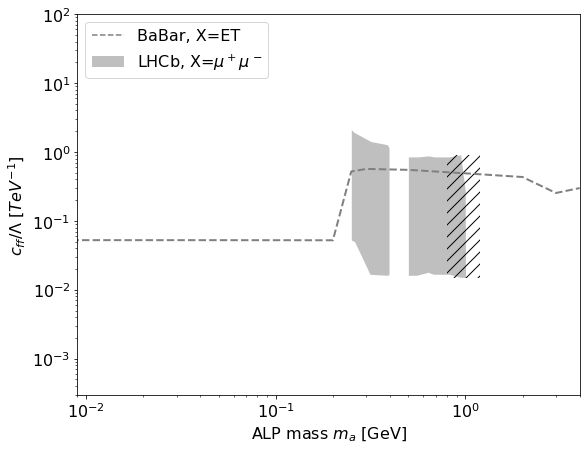

In [69]:
fig, ax = plt.subplots(figsize=(9, 7))

ax.plot(BaBarBounds[:,0],BaBarBounds[:,1],c="grey", ls='--',lw=2)

plotGen(fromLambdatof(LHCbBoundscff),"oppacpolygon","grey",0,0.5, label='LHCb, X=$\mu^+ \mu^-$')

plotWhiteRegions(10**(2))



p = mpatches.Rectangle((0.8,1.5*10**-2), 0.4, 0.9, linewidth=0, fill=None, hatch='//')
ax.add_patch(p)

# ax.set_title('Bounds on $BR( B^+ \\rightarrow K^+ + X )$')

ax.set_xlabel('ALP mass $m_a$ [GeV]')
ax.set_ylabel('$c_{ff}/\Lambda\ [TeV^{-1}]$')
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlim(9*10**-3, 4)
ax.set_ylim(3*10**-4, 10**2)

handles, labels = ax.get_legend_handles_labels()
babar= mlines.Line2D([], [], color='grey', linestyle='--',
                          markersize=15, label='BaBar, X='+"ET")
handles.insert(0, babar) 

ax.legend(handles=handles,loc='upper left')



plt.savefig('plots/Bound-LHCb-BaBar-cff.png', dpi=300, bbox_inches='tight')

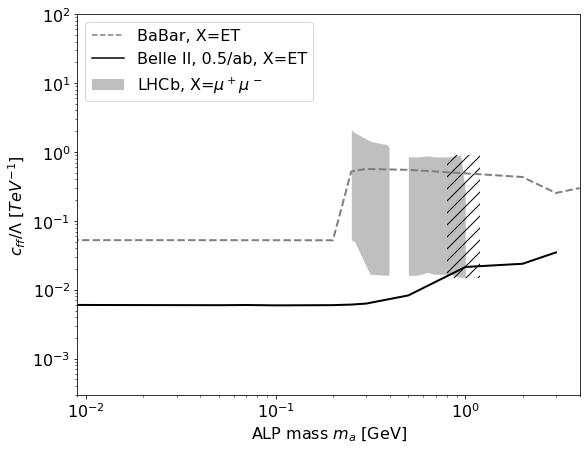

In [78]:
fig, ax = plt.subplots(figsize=(9, 7))

ax.plot(BaBarBounds[:,0],BaBarBounds[:,1],c="grey", ls='--',lw=2)

ax.plot(BellIIInvBounds05ab[:,0],BellIIInvBounds05ab[:,1],c="black", ls='-',lw=2)

plotGen(fromLambdatof(LHCbBoundscff),"oppacpolygon","grey",0,0.5, label='LHCb, X=$\mu^+ \mu^-$')

plotWhiteRegions(10**(2))



p = mpatches.Rectangle((0.8,1.5*10**-2), 0.4, 0.9, linewidth=0, fill=None, hatch='//')
ax.add_patch(p)

# ax.set_title('Bounds on $BR( B^+ \\rightarrow K^+ + X )$')

ax.set_xlabel('ALP mass $m_a$ [GeV]')
ax.set_ylabel('$c_{ff}/\Lambda\ [TeV^{-1}]$')
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlim(9*10**-3, 4)
ax.set_ylim(3*10**-4, 10**2)

handles, labels = ax.get_legend_handles_labels()
babar= mlines.Line2D([], [], color='grey', linestyle='--',
                          markersize=15, label='BaBar, X='+"ET")
belleIIInv= mlines.Line2D([], [], color='black', linestyle='-',
                          markersize=15, label='Belle II, 0.5/ab, X='+"ET")
handles.insert(0, belleIIInv) 
handles.insert(0, babar) 

ax.legend(handles=handles,loc='upper left')



plt.savefig('plots/Bound-LHCb-BaBar-BelleIIInv-cff.png', dpi=300, bbox_inches='tight')

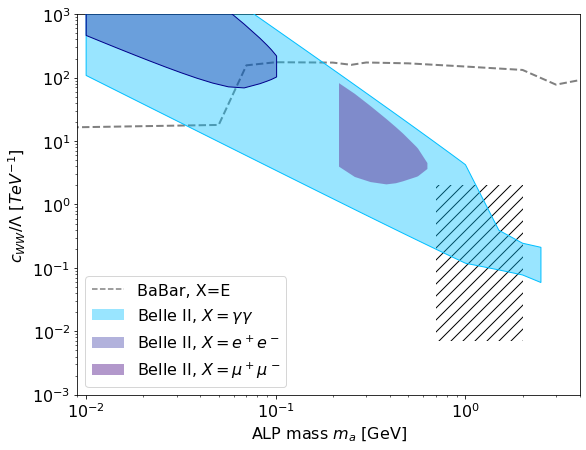

In [98]:
fig, ax = plt.subplots(figsize=(9, 7))

ax.plot(BaBarBounds[:,0],BaBarBounds[:,2],c="grey", ls='--',lw=2)

#plotGen(fromLambdatof(LHCbBoundscWW),"oppacpolygon","grey",0,0.5, label='LHCb, X=$\mu^+ \mu^-$')
# plotGen(LHCbBounds,"nonfilledpolygon","grey",1)
#plotWhiteRegions(10**(2))

plotGen(stackBounds(masslist,readArrayVisibleBoundBelleIIcWW[:,5,0]*(4*np.pi),\
                    readArrayVisibleBoundBelleIIcWW[:,5,1]*(4*np.pi)),"oppacpolygon","deepskyblue",0,0.4,\
                    label='Belle II, $X=\gamma \gamma $',zorder=3)
plotGen(stackBounds(masslist,readArrayVisibleBoundBelleIIcWW[:,5,0]*(4*np.pi),\
                    readArrayVisibleBoundBelleIIcWW[:,5,1]*(4*np.pi)),"nonfilledpolygon","deepskyblue",1,zorder=3)

plotGen(stackBounds(masslist,readArrayVisibleBoundBelleIIcWW[:,0,0]*(4*np.pi),\
                    readArrayVisibleBoundBelleIIcWW[:,0,1]*(4*np.pi)),"oppacpolygon","darkblue",0,0.3,\
                    label='Belle II, $X=e^+ e^-$',zorder=3)
plotGen(stackBounds(masslist,readArrayVisibleBoundBelleIIcWW[:,0,0]*(4*np.pi),\
                    readArrayVisibleBoundBelleIIcWW[:,0,1]*(4*np.pi)),"nonfilledpolygon","darkblue",1,zorder=3)

plotGen(stackBounds(masslist,readArrayVisibleBoundBelleIIcWW[:,1,0]*(4*np.pi),\
                    readArrayVisibleBoundBelleIIcWW[:,1,1]*(4*np.pi)),"oppacpolygon","rebeccapurple",0,0.5,\
                    label='Belle II, $X=\mu^+ \mu^-$',zorder=3)
# plotGen(stackBounds(masslist,readArrayVisibleBoundBelleIIcff[:,1,0],\
#                     readArrayVisibleBoundBelleIIcff[:,1,1]),"nonfilledpolygon","rebeccapurple",1)

p = mpatches.Rectangle((0.7,7*10**-3), 1.3, 2, linewidth=0, fill=None, hatch='//')
ax.add_patch(p)


# ax.set_title('Projected bounds on $BR( B^+ \\rightarrow K^+ + X )$')

ax.set_xlabel('ALP mass $m_a$ [GeV]')
ax.set_ylabel('$c_{WW}/\Lambda\ [TeV^{-1}]$')
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlim(9*10**-3, 4)
ax.set_ylim(10**-3, 4*np.pi*10**3)

handles, labels = ax.get_legend_handles_labels()
babar= mlines.Line2D([], [], color='grey', linestyle='--',
                          markersize=15, label='BaBar, X='+"E")
handles.insert(0, babar) 

ax.legend(handles=handles)



plt.savefig('plots/BoundBelleII-cWW-projections.png', dpi=300, bbox_inches='tight')

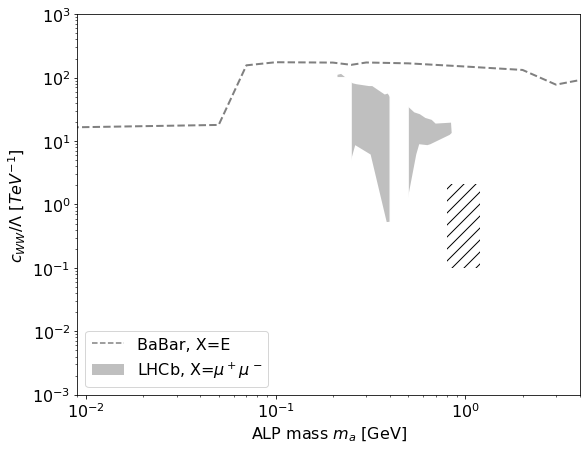

In [58]:
fig, ax = plt.subplots(figsize=(9, 7))

ax.plot(BaBarBounds[:,0],BaBarBounds[:,2],c="grey", ls='--',lw=2)

plotGen(fromLambdatof(LHCbBoundscWW),"oppacpolygon","grey",0,0.5, label='LHCb, X=$\mu^+ \mu^-$')
plotWhiteRegions(10**(2))


p = mpatches.Rectangle((0.8,10**-1), 0.4, 2, linewidth=0, fill=None, hatch='//')
ax.add_patch(p)

# ax.set_title('Bounds on $BR( B^+ \\rightarrow K^+ + X )$')

ax.set_xlabel('ALP mass $m_a$ [GeV]')
ax.set_ylabel('$c_{WW}/\Lambda\ [TeV^{-1}]$')
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlim(9*10**-3, 4)
ax.set_ylim(10**-3, 4*np.pi*10**3)

handles, labels = ax.get_legend_handles_labels()
babar= mlines.Line2D([], [], color='grey', linestyle='--',
                          markersize=15, label='BaBar, X='+"E")
handles.insert(0, babar) 

ax.legend(handles=handles)



plt.savefig('plots/BoundBelleII-cWW.png', dpi=300, bbox_inches='tight')

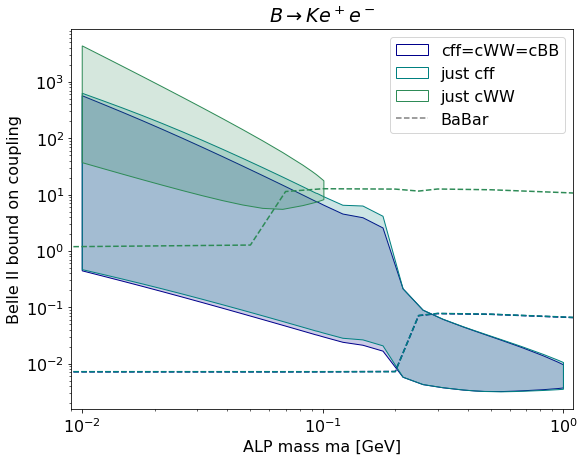

In [44]:
fig, ax = plt.subplots(figsize=(9, 7))

# ax.plot(masslist,readArrayVisibleBoundBelleIIcffEqcWWEqcBB[:,0,0],label='cff=cWW=cBB',c="darkblue") 
# ax.plot(masslist,readArrayVisibleBoundBelleIIcffEqcWWEqcBB[:,0,1],c="darkblue")
# ax.plot(BaBarBounds[:,0],BaBarBounds[:,1],c="darkblue", ls='--')

# ax.plot(masslist,readArrayVisibleBoundBelleIIcff[:,0,0],label='just cff',c="teal") 
# ax.plot(masslist,readArrayVisibleBoundBelleIIcff[:,0,1],c="teal") 
# ax.plot(BaBarBounds[:,0],BaBarBounds[:,2],c="teal", ls='-.')

# ax.plot(masslist,readArrayVisibleBoundBelleIIcWW[:,0,0],label='just cWW',c="mediumseagreen") 
# ax.plot(masslist,readArrayVisibleBoundBelleIIcWW[:,0,1],c="mediumseagreen") 
# ax.plot(BaBarBounds[:,0],BaBarBounds[:,3],c="mediumseagreen", ls='--')


plotGen(stackBounds(masslist,readArrayVisibleBoundBelleIIcffEqcWWEqcBB[:,0,0],\
                    readArrayVisibleBoundBelleIIcffEqcWWEqcBB[:,0,1]),"oppacpolygon","darkblue",0,0.2)
plotGen(stackBounds(masslist,readArrayVisibleBoundBelleIIcffEqcWWEqcBB[:,0,0],\
                    readArrayVisibleBoundBelleIIcffEqcWWEqcBB[:,0,1]),"nonfilledpolygon","darkblue",1,\
                    label='cff=cWW=cBB')
ax.plot(BaBarBounds[:,0],BaBarBounds[:,1],c="darkblue", ls='--')

plotGen(stackBounds(masslist,readArrayVisibleBoundBelleIIcff[:,0,0],\
                    readArrayVisibleBoundBelleIIcff[:,0,1]),"oppacpolygon","teal",0,0.2)
plotGen(stackBounds(masslist,readArrayVisibleBoundBelleIIcff[:,0,0],\
                    readArrayVisibleBoundBelleIIcff[:,0,1]),"nonfilledpolygon","teal",1,\
                    label='just cff')
ax.plot(BaBarBounds[:,0],BaBarBounds[:,2],c="teal", ls='--')

plotGen(stackBounds(masslist,readArrayVisibleBoundBelleIIcWW[:,0,0],\
                    readArrayVisibleBoundBelleIIcWW[:,0,1]),"oppacpolygon","seagreen",0,0.2)
plotGen(stackBounds(masslist,readArrayVisibleBoundBelleIIcWW[:,0,0],\
                    readArrayVisibleBoundBelleIIcWW[:,0,1]),"nonfilledpolygon","seagreen",1,
                    label='just cWW')
ax.plot(BaBarBounds[:,0],BaBarBounds[:,3],c="seagreen", ls='--')


ax.set_title('$B\\rightarrow K e^+ e^-$')

ax.set_xlabel('ALP mass ma [GeV]')
ax.set_ylabel('Belle II bound on coupling')
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlim(9*10**-3, 1.1)

handles, labels = ax.get_legend_handles_labels()
babar= mlines.Line2D([], [], color='gray', linestyle='--',
                          markersize=15, label='BaBar')
handles.append(babar) 

ax.legend(handles=handles)



plt.savefig('plots/visibleBoundBelleII-electrons.png', dpi=300, bbox_inches='tight')

In [109]:
masslist

array([0.01      , 0.01211528, 0.01467799, 0.01778279, 0.02154435,
       0.02610157, 0.03162278, 0.03831187, 0.04641589, 0.05623413,
       0.06812921, 0.08254042, 0.09      , 0.0935    , 0.095     ,
       0.1       , 0.101     , 0.12115277, 0.14677993, 0.17782794,
       0.21544347, 0.26101572, 0.31622777, 0.38311868, 0.43      ,
       0.46415888, 0.47      , 0.55      , 0.56234133, 0.63      ,
       0.65      , 0.68129207, 0.82540419, 0.95      , 1.        ,
       1.        , 1.5       , 2.        , 2.5       , 3.        ,
       3.2       , 3.5       , 4.        ])

In [39]:
visibleBoundBelleIIcWW(0.0935,0,4*np.pi*10**3,3)

<ipython-input-29-8deba696dce2>:37: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  nsignalAt95CLBelleIIcWWEstimate=np.vstack(([coupling,nsignalAt95CLBelleIIcWW(coupling,ma,finalStateCode,\
<ipython-input-17-994b222f9bd8>:50: ComplexWarning: Casting complex values to real discards the imaginary part
  return float(gamma)
<ipython-input-27-1f1779c84ac1>:8: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  return 1/(4 * (gammaBeta * ctau)**2) * integrate.quad(lambda theta: (1/np.sin(theta)) \
<ipython-input-27-1f1779c84ac1>:8: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (s

[7.285732176015176, 22.97336077322689]

In [40]:
visibleBoundBelleIIcffEqcWWEqcBB(0.95,0,4*np.pi*10**3,3)

<ipython-input-29-8deba696dce2>:2: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  nsignalAt95CLBelleIIAllcEqualEstimate=np.vstack(([coupling,nsignalAt95CLBelleIIAllcEqual(\
<ipython-input-17-994b222f9bd8>:50: ComplexWarning: Casting complex values to real discards the imaginary part
  return float(gamma)
<ipython-input-18-f936f951c6e4>:12: ComplexWarning: Casting complex values to real discards the imaginary part
  return float(gamma)
<ipython-input-18-f936f951c6e4>:25: ComplexWarning: Casting complex values to real discards the imaginary part
  return float(gamma)
<ipython-input-27-1f1779c84ac1>:8: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the positio

[0.0036186024612067896, 0.01060248234885637]

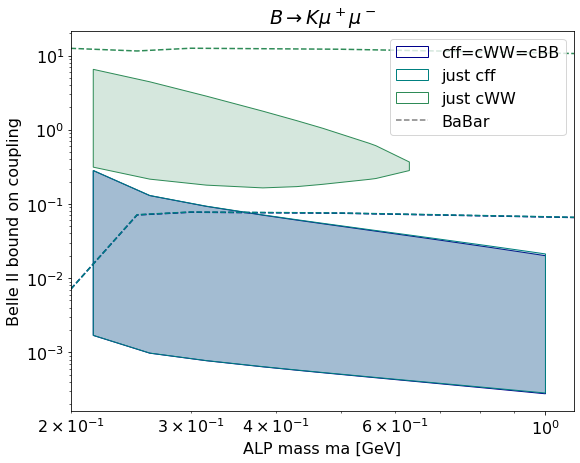

In [112]:
outputfig, ax = plt.subplots(figsize=(9, 7))

# ax.plot(masslist,readArrayVisibleBoundBelleIIcffEqcWWEqcBB[:,1,0],label='cff=cWW=cBB',c="darkblue") 
# ax.plot(masslist,readArrayVisibleBoundBelleIIcffEqcWWEqcBB[:,1,1],c="darkblue") 
# ax.plot(BaBarBounds[:,0],BaBarBounds[:,1],c="darkblue", ls='--')

# ax.plot(masslist,readArrayVisibleBoundBelleIIcff[:,1,0],label='just cff',c="teal") 
# ax.plot(masslist,readArrayVisibleBoundBelleIIcff[:,1,1],c="teal") 
# ax.plot(BaBarBounds[:,0],BaBarBounds[:,2],c="teal", ls='-.')

# ax.plot(masslist,readArrayVisibleBoundBelleIIcWW[:,1,0],label='just cWW',c="mediumseagreen") 
# ax.plot(masslist,readArrayVisibleBoundBelleIIcWW[:,1,1],c="mediumseagreen") 
# ax.plot(BaBarBounds[:,0],BaBarBounds[:,3],c="mediumseagreen", ls='--')

plotGen(stackBounds(masslist,readArrayVisibleBoundBelleIIcffEqcWWEqcBB[:,1,0],\
                    readArrayVisibleBoundBelleIIcffEqcWWEqcBB[:,1,1]),"oppacpolygon","darkblue",0,0.2)
plotGen(stackBounds(masslist,readArrayVisibleBoundBelleIIcffEqcWWEqcBB[:,1,0],\
                    readArrayVisibleBoundBelleIIcffEqcWWEqcBB[:,1,1]),"nonfilledpolygon","darkblue",1,\
                    label='cff=cWW=cBB')
ax.plot(BaBarBounds[:,0],BaBarBounds[:,1],c="darkblue", ls='--')

plotGen(stackBounds(masslist,readArrayVisibleBoundBelleIIcff[:,1,0],\
                    readArrayVisibleBoundBelleIIcff[:,1,1]),"oppacpolygon","teal",0,0.2)
plotGen(stackBounds(masslist,readArrayVisibleBoundBelleIIcff[:,1,0],\
                    readArrayVisibleBoundBelleIIcff[:,1,1]),"nonfilledpolygon","teal",1,\
                    label='just cff')
ax.plot(BaBarBounds[:,0],BaBarBounds[:,2],c="teal", ls='--')

plotGen(stackBounds(masslist,readArrayVisibleBoundBelleIIcWW[:,1,0],\
                    readArrayVisibleBoundBelleIIcWW[:,1,1]),"oppacpolygon","seagreen",0,0.2)
plotGen(stackBounds(masslist,readArrayVisibleBoundBelleIIcWW[:,1,0],\
                    readArrayVisibleBoundBelleIIcWW[:,1,1]),"nonfilledpolygon","seagreen",1,
                    label='just cWW')
ax.plot(BaBarBounds[:,0],BaBarBounds[:,3],c="seagreen", ls='--')

ax.set_title('$B\\rightarrow K \\mu^+ \\mu^-$')

ax.set_xlabel('ALP mass ma [GeV]')
ax.set_ylabel('Belle II bound on coupling')
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlim(2*10**-1, 1.1)

handles, labels = ax.get_legend_handles_labels()
babar= mlines.Line2D([], [], color='gray', linestyle='--',
                          markersize=15, label='BaBar')
handles.append(babar) 

ax.legend(handles=handles)

plt.savefig('plots/visibleBoundBelleII-muons.png', dpi=300, bbox_inches='tight')

In [113]:
visibleBoundBelleIIcff(2,1,4*np.pi*10**3,3)

<ipython-input-83-f7ef24db5db7>:23: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  nsignalAt95CLBelleIIcffEstimate=np.vstack(([coupling,nsignalAt95CLBelleIIcff(coupling,ma,finalStateCode,\
<ipython-input-19-de56bdf3d9c0>:46: ComplexWarning: Casting complex values to real discards the imaginary part
  return float(gamma)
<ipython-input-19-de56bdf3d9c0>:109: ComplexWarning: Casting complex values to real discards the imaginary part
  return float(gamma)


[nan, nan]

In [114]:
visibleBoundBelleIIcWW(0.63,1,4*np.pi*10**3,3)

<ipython-input-83-f7ef24db5db7>:38: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  nsignalAt95CLBelleIIcWWEstimate=np.vstack(([coupling,nsignalAt95CLBelleIIcWW(coupling,ma,finalStateCode,\
<ipython-input-19-de56bdf3d9c0>:46: ComplexWarning: Casting complex values to real discards the imaginary part
  return float(gamma)
<ipython-input-58-1f1779c84ac1>:8: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  return 1/(4 * (gammaBeta * ctau)**2) * integrate.quad(lambda theta: (1/np.sin(theta)) \
<ipython-input-58-1f1779c84ac1>:8: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (s

[0.28186412099791874, 0.3675339850597292]

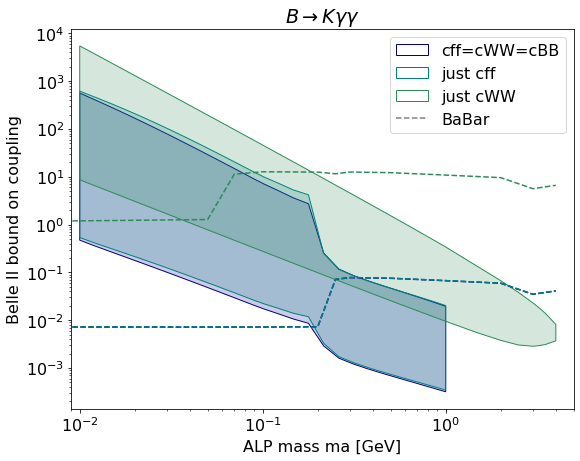

In [117]:
fig, ax = plt.subplots(figsize=(9, 7))

# ax.plot(masslist,readArrayVisibleBoundBelleIIcffEqcWWEqcBB[:,5,0],label='cff=cWW=cBB',c="darkblue") 
# ax.plot(masslist,readArrayVisibleBoundBelleIIcffEqcWWEqcBB[:,5,1],c="darkblue") 
# ax.plot(BaBarBounds[:,0],BaBarBounds[:,1],c="darkblue", ls='--')

# ax.plot(masslist,readArrayVisibleBoundBelleIIcff[:,5,0],label='just cff',c="teal") 
# ax.plot(masslist,readArrayVisibleBoundBelleIIcff[:,5,1],c="teal") 
# ax.plot(BaBarBounds[:,0],BaBarBounds[:,2],c="teal", ls='-.')

# ax.plot(masslist,readArrayVisibleBoundBelleIIcWW[:,5,0],label='just cWW',c="mediumseagreen") 
# ax.plot(masslist,readArrayVisibleBoundBelleIIcWW[:,5,1],c="mediumseagreen") 
# ax.plot(BaBarBounds[:,0],BaBarBounds[:,3],c="mediumseagreen", ls='--')

plotGen(stackBounds(masslist,readArrayVisibleBoundBelleIIcffEqcWWEqcBB[:,5,0],\
                    readArrayVisibleBoundBelleIIcffEqcWWEqcBB[:,5,1]),"oppacpolygon","darkblue",0,0.2)
plotGen(stackBounds(masslist,readArrayVisibleBoundBelleIIcffEqcWWEqcBB[:,5,0],\
                    readArrayVisibleBoundBelleIIcffEqcWWEqcBB[:,5,1]),"nonfilledpolygon","darkblue",1,\
                    label='cff=cWW=cBB')
ax.plot(BaBarBounds[:,0],BaBarBounds[:,1],c="darkblue", ls='--')

plotGen(stackBounds(masslist,readArrayVisibleBoundBelleIIcff[:,5,0],\
                    readArrayVisibleBoundBelleIIcff[:,5,1]),"oppacpolygon","teal",0,0.2)
plotGen(stackBounds(masslist,readArrayVisibleBoundBelleIIcff[:,5,0],\
                    readArrayVisibleBoundBelleIIcff[:,5,1]),"nonfilledpolygon","teal",1,\
                    label='just cff')
ax.plot(BaBarBounds[:,0],BaBarBounds[:,2],c="teal", ls='--')

plotGen(stackBounds(masslist,readArrayVisibleBoundBelleIIcWW[:,5,0],\
                    readArrayVisibleBoundBelleIIcWW[:,5,1]),"oppacpolygon","seagreen",0,0.2)
plotGen(stackBounds(masslist,readArrayVisibleBoundBelleIIcWW[:,5,0],\
                    readArrayVisibleBoundBelleIIcWW[:,5,1]),"nonfilledpolygon","seagreen",1,
                    label='just cWW')
ax.plot(BaBarBounds[:,0],BaBarBounds[:,3],c="seagreen", ls='--')

ax.set_title('$B\\rightarrow K \\gamma \\gamma$')

ax.set_xlabel('ALP mass ma [GeV]')
ax.set_ylabel('Belle II bound on coupling')
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlim(9*10**-3, 5)

handles, labels = ax.get_legend_handles_labels()
babar= mlines.Line2D([], [], color='gray', linestyle='--',
                          markersize=15, label='BaBar')
handles.append(babar) 

ax.legend(handles=handles)

plt.savefig('plots/visibleBoundBelleII-photons.png', dpi=300, bbox_inches='tight')

In [1]:
visibleBoundBelleIIcWW(0.01,5,4*np.pi*10**3,3)

NameError: name 'visibleBoundBelleIIcWW' is not defined

In [119]:
visibleBoundBelleIIcWW(0.01,5,4*np.pi*10**3,3)

<ipython-input-83-f7ef24db5db7>:38: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  nsignalAt95CLBelleIIcWWEstimate=np.vstack(([coupling,nsignalAt95CLBelleIIcWW(coupling,ma,finalStateCode,\
<ipython-input-19-de56bdf3d9c0>:46: ComplexWarning: Casting complex values to real discards the imaginary part
  return float(gamma)
<ipython-input-58-1f1779c84ac1>:8: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  return 1/(4 * (

[8.620748230910424, 5467.003330541351]

## Generate [ma, tau, c, BR(theory)] files

In [36]:
masslist

array([0.01      , 0.01211528, 0.01467799, 0.01778279, 0.02154435,
       0.02610157, 0.03162278, 0.03831187, 0.04641589, 0.05623413,
       0.06812921, 0.08254042, 0.09      , 0.0935    , 0.095     ,
       0.1       , 0.101     , 0.12115277, 0.14677993, 0.17782794,
       0.21544347, 0.26101572, 0.31622777, 0.38311868, 0.43      ,
       0.46415888, 0.47      , 0.55      , 0.56234133, 0.63      ,
       0.65      , 0.68129207, 0.82540419, 0.95      , 1.        ,
       1.        , 1.5       , 2.        , 2.5       , 3.        ,
       3.2       , 3.5       , 4.        ])

In [38]:
couplingList

array([1.00000000e-06, 3.35981829e-06, 1.12883789e-05, 3.79269019e-05,
       1.27427499e-04, 4.28133240e-04, 1.43844989e-03, 4.83293024e-03,
       1.62377674e-02, 5.45559478e-02, 1.00000000e-01, 1.43844989e-01,
       1.83298071e-01, 2.06913808e-01, 2.97635144e-01, 4.28133240e-01,
       6.15848211e-01, 6.15848211e-01, 8.85866790e-01, 1.27427499e+00,
       1.83298071e+00, 2.06913808e+00, 2.63665090e+00, 3.79269019e+00,
       5.45559478e+00, 6.95192796e+00, 7.84759970e+00, 1.12883789e+01,
       1.62377674e+01, 2.33572147e+01, 2.33572147e+01, 3.35981829e+01,
       4.83293024e+01, 6.95192796e+01, 7.84759970e+01, 1.00000000e+02,
       2.63665090e+02, 8.85866790e+02, 2.97635144e+03, 1.00000000e+04])

In [33]:
def generateLHCbFiles(mlist,clist,process,Lambda):
    
    with HiddenPrints():
    
        lhcbList=[['# m [GeV], tau [ps], c, BR_theo(B->K mu mu)\n']]

        for ma in mlist:
            for c in clist:

#                 if process in ['cff=cWW=cBB']:
#                     #print("1")
#                     cQ=cL=cWW=cBB=cff=c
#                     ce=cd=cu=-c
#                     cGG=0

                if process in ['cWW']:
                    #print("2")
                    cQ=cL=cu=cd=ce=cGG=cBB=cff=0
                    cWW=c


                if process in ['cff']:
                    #print("3")
                    cGG=cWW=cBB=0
                    cQ=cL=cff=c
                    ce=cd=cu=-c

                coefs=getLScoefficients(cff, cWW, cBB, Lambda, ma)
                cbs=getCbs(cff, cWW, cBB, Lambda, sm['mB+'])

                BR= BrBtoKaplus(ma, cbs, Lambda) \
                *brALPtoOneFinalState(ma,1,cQ,cu,cd,cL,ce,cGG,cWW,cBB,Lambda,None)[0]
                tau=ctaua(ma, cff, cWW, cBB, Lambda)/sm['c']*10**12

                lhcbList.append([ma,tau,c,BR])
        return lhcbList

In [34]:
# meshcffcWWcBB=generateLHCbFiles(masslistShort,couplingListShort,'cff=cWW=cBB',4*np.pi*10**3)

In [39]:
meshcWW=generateLHCbFiles(masslist,couplingList,'cWW',4*np.pi*10**3)
meshcff=generateLHCbFiles(masslist,couplingList,'cff',4*np.pi*10**3)

<ipython-input-16-8c939a5a82a1>:48: ComplexWarning: Casting complex values to real discards the imaginary part
  return float(gamma)
<ipython-input-16-8c939a5a82a1>:88: ComplexWarning: Casting complex values to real discards the imaginary part
  return float(gamma)
<ipython-input-16-8c939a5a82a1>:101: ComplexWarning: Casting complex values to real discards the imaginary part
  return float(gamma)
<ipython-input-16-8c939a5a82a1>:75: ComplexWarning: Casting complex values to real discards the imaginary part
  return float(gamma)


In [40]:
# with open("output/m-tau-c-BRBtoKmumu-cffcWWcBB.dat", "w", newline="") as f:
#     writer = csv.writer(f,delimiter=",", quoting = csv.QUOTE_NONE,escapechar=' ')
#     writer.writerows(meshcffcWWcBB)
    
with open("output/m-tau-c-BRBtoKmumu-cWW.dat", "w", newline="") as f:
    writer = csv.writer(f,delimiter=",", quoting = csv.QUOTE_NONE,escapechar=' ')
    writer.writerows(meshcWW)
    
with open("output/m-tau-c-BRBtoKmumu-cff.dat", "w", newline="") as f:
    writer = csv.writer(f,delimiter=",", quoting = csv.QUOTE_NONE,escapechar=' ')
    writer.writerows(meshcff)

In [41]:
ctaua(0.9,5.010311e-04,0,0,4*np.pi*10**3)/sm['c']*10**12

no valid value for the low scale chosen. Has do be higher than the QCD confinement scale!
Returning the value of the coefficients at mtau/


<ipython-input-16-8c939a5a82a1>:101: ComplexWarning: Casting complex values to real discards the imaginary part
  return float(gamma)
<ipython-input-16-8c939a5a82a1>:88: ComplexWarning: Casting complex values to real discards the imaginary part
  return float(gamma)
<ipython-input-16-8c939a5a82a1>:48: ComplexWarning: Casting complex values to real discards the imaginary part
  return float(gamma)


1468.2136323485731

In [61]:
ctaua(0.9,5.010311e-04,0,0,4*np.pi*10**3)/sm['c']*10**12

no valid value for the low scale chosen. Has do be higher than the QCD confinement scale!
Returning the value of the coefficients at mtau/


<ipython-input-18-f936f951c6e4>:25: ComplexWarning: Casting complex values to real discards the imaginary part
  return float(gamma)
<ipython-input-18-f936f951c6e4>:12: ComplexWarning: Casting complex values to real discards the imaginary part
  return float(gamma)
<ipython-input-17-994b222f9bd8>:50: ComplexWarning: Casting complex values to real discards the imaginary part
  return float(gamma)


1302.3721120163134

In [30]:
ctaua(2,5.010311e-04,0,0,4*np.pi*10**3)/sm['c']*10**12

<ipython-input-16-8c939a5a82a1>:75: ComplexWarning: Casting complex values to real discards the imaginary part
  return float(gamma)
<ipython-input-16-8c939a5a82a1>:48: ComplexWarning: Casting complex values to real discards the imaginary part
  return float(gamma)


0.001934240134411004

In [62]:
ctaua(2,5.010311e-04,0,0,4*np.pi*10**3)/sm['c']*10**12

<ipython-input-17-994b222f9bd8>:76: ComplexWarning: Casting complex values to real discards the imaginary part
  return float(gamma)
<ipython-input-17-994b222f9bd8>:50: ComplexWarning: Casting complex values to real discards the imaginary part
  return float(gamma)


0.2348680373043248

In [88]:
maList = list((i*10**(exp-2) for exp in range(-3, 2) for i in range(10, 100)))
ctauaList=[]
with HiddenPrints():
    for ma in maList:
        ctauaList.append(ctaua(ma, 5.010311e-04, 0, 0, 4*np.pi*10**3)/sm['c']*10**12)
        
brList=[]
with HiddenPrints():
    for ma in maList:
        brList.append(brALPtoOneFinalState(ma,1,5.010311e-04,-5.010311e-04,-5.010311e-04,5.010311e-04,\
                                           -5.010311e-04,0,0,0,4*np.pi*10**3)[0])

<ipython-input-17-994b222f9bd8>:50: ComplexWarning: Casting complex values to real discards the imaginary part
  return float(gamma)
<ipython-input-18-f936f951c6e4>:12: ComplexWarning: Casting complex values to real discards the imaginary part
  return float(gamma)
<ipython-input-18-f936f951c6e4>:25: ComplexWarning: Casting complex values to real discards the imaginary part
  return float(gamma)
<ipython-input-17-994b222f9bd8>:76: ComplexWarning: Casting complex values to real discards the imaginary part
  return float(gamma)


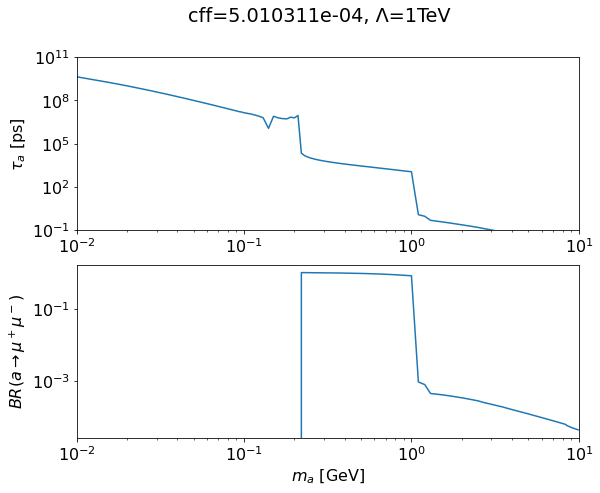

In [98]:
fig, ax = plt.subplots(2,figsize=(9, 7))
plt.suptitle("cff=5.010311e-04, \u039B=1TeV")
#plt.xlim(10**-2,10**1)
# plt.ylim(10**-2,10**8)

ax[0].plot(maList,ctauaList)
ax[0].set_ylabel('$\\tau_a$ [ps]')
ax[0].set_xlim(10**-2,10)
ax[0].set_ylim(10**-1,10**11)

ax[1].plot(maList,brList)
ax[1].set_ylabel('$BR(a \\rightarrow \\mu^+ \\mu^-)$')
ax[1].set_xlabel('$m_a$ [GeV]')
ax[1].set_xlim(10**-2,10)


ax[0].set_xscale('log')
ax[0].set_yscale('log')

ax[1].set_xscale('log')
ax[1].set_yscale('log')


plt.savefig('plots/LHCb_cff-fixed_BRandTau.png', dpi=300, bbox_inches='tight')

<ipython-input-17-994b222f9bd8>:50: ComplexWarning: Casting complex values to real discards the imaginary part
  return float(gamma)
<ipython-input-18-f936f951c6e4>:12: ComplexWarning: Casting complex values to real discards the imaginary part
  return float(gamma)
<ipython-input-18-f936f951c6e4>:25: ComplexWarning: Casting complex values to real discards the imaginary part
  return float(gamma)
<ipython-input-17-994b222f9bd8>:76: ComplexWarning: Casting complex values to real discards the imaginary part
  return float(gamma)


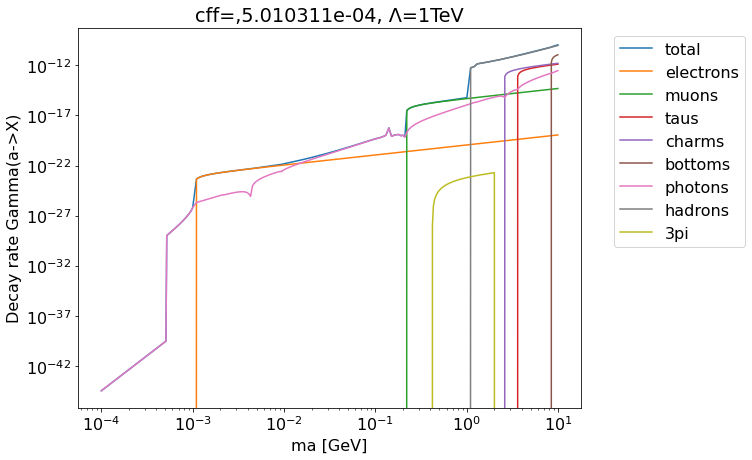

In [47]:
brsALP(5.010311e-04,-5.010311e-04,-5.010311e-04,5.010311e-04,-5.010311e-04,0,0,0,"cff=,5.010311e-04, \u039B=1TeV",1000,br=False,lower=10**-20)

In [78]:
brALPtoOneFinalState(0.5,1,5.010311e-04,-5.010311e-04,-5.010311e-04,5.010311e-04,-5.010311e-04,0,0,0,4*np.pi*10**3)[0]

<ipython-input-17-994b222f9bd8>:50: ComplexWarning: Casting complex values to real discards the imaginary part
  return float(gamma)
<ipython-input-18-f936f951c6e4>:12: ComplexWarning: Casting complex values to real discards the imaginary part
  return float(gamma)
<ipython-input-18-f936f951c6e4>:25: ComplexWarning: Casting complex values to real discards the imaginary part
  return float(gamma)


0.9419592557580478